In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_data = pd.read_excel("data/train.xlsx")
test_data = pd.read_excel("data/test.xlsx")
    
print("Первые 5 строк данных:")
print(train_data.head())
print(test_data.head())

print("\nИнформация о данных:")
print(train_data.info())
print(test_data.info())

print("\nОписательная статистика:")
print(train_data.describe())
print(test_data.describe())

print("\nПропущенные значения:")
print(train_data.isnull().sum())
print(test_data.isnull().sum())

print("\nКоличество дубликатов:")
print(train_data.duplicated().sum())
print(test_data.duplicated().sum())

Первые 5 строк данных:
          dt  Price
0 2015-01-05  32900
1 2015-01-12  32500
2 2015-01-19  32000
3 2015-01-26  30700
4 2015-02-02  30300
          dt  Price
0 2022-09-05  46000
1 2022-09-12  46000
2 2022-09-19  46000
3 2022-09-26  45500
4 2022-10-03  45500

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dt      400 non-null    datetime64[ns]
 1   Price   400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dt      28 non-null     datetime64[ns]
 1   Price   28 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 580.0 bytes
None

Описательная статистика:
  

In [2]:
for col in test_data.columns:
    pct_missing = np.mean(test_data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

dt - 0%
Price - 0%


In [3]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Извлечение признаков из даты
train_data['dt'] = pd.to_datetime(train_data['dt'])
train_data['year'] = train_data['dt'].dt.year
train_data['month'] = train_data['dt'].dt.month
train_data['day'] = train_data['dt'].dt.day
train_data['dayofweek'] = train_data['dt'].dt.dayofweek
train_data['week'] = train_data['dt'].dt.isocalendar().week

# Признаки (X) и целевая переменная (y)
X = train_data.drop(columns=["Price"])  # Удаляем только целевую переменную
y = train_data["Price"]

# Разделение данных на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели с более сложными параметрами
model = CatBoostRegressor(
    iterations=1000,  # Увеличиваем количество итераций
    learning_rate=0.05,
    depth=6,  # Увеличиваем глубину дерева
    l2_leaf_reg=5,
    verbose=100,
    early_stopping_rounds=50  # Добавляем раннюю остановку
)

model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# Прогнозирование на тестовых данных
test_data['dt'] = pd.to_datetime(test_data['dt'])
test_data['year'] = test_data['dt'].dt.year
test_data['month'] = test_data['dt'].dt.month
test_data['day'] = test_data['dt'].dt.day
test_data['dayofweek'] = test_data['dt'].dt.dayofweek
test_data['week'] = test_data['dt'].dt.isocalendar().week

X_test = test_data.drop(columns=["Price"])  # Удаляем только целевую переменную
y_test = test_data["Price"]

y_pred = model.predict(X_test)

# Оценка модели
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

model.save_model("catboost_model.pkl")

0:	learn: 13117.3452479	test: 12291.3371998	best: 12291.3371998 (0)	total: 141ms	remaining: 2m 21s
100:	learn: 3143.3770553	test: 4295.6340052	best: 4295.6340052 (100)	total: 202ms	remaining: 1.79s
200:	learn: 1985.1783427	test: 3045.5194912	best: 3045.5194912 (200)	total: 270ms	remaining: 1.07s
300:	learn: 1414.5795515	test: 2563.0075680	best: 2563.0075680 (300)	total: 341ms	remaining: 793ms
400:	learn: 1067.0227048	test: 2288.6006393	best: 2288.4567478 (399)	total: 409ms	remaining: 611ms
500:	learn: 864.1966565	test: 2114.7350306	best: 2114.7350306 (500)	total: 475ms	remaining: 473ms
600:	learn: 724.0585361	test: 1993.7356073	best: 1993.7356073 (600)	total: 539ms	remaining: 358ms
700:	learn: 633.1777784	test: 1910.6525593	best: 1910.6525593 (700)	total: 605ms	remaining: 258ms
800:	learn: 544.8689190	test: 1840.4042288	best: 1840.4042288 (800)	total: 671ms	remaining: 167ms
900:	learn: 477.7563647	test: 1791.5565432	best: 1791.5565432 (900)	total: 737ms	remaining: 81ms
999:	learn: 419.

In [5]:
from catboost import CatBoostRegressor
import pandas as pd

# Загрузка модели
model = CatBoostRegressor()
model.load_model("catboost_model.pkl")

# Преобразуем столбец 'dt' в datetime, если это еще не сделано
test_data['dt'] = pd.to_datetime(test_data['dt'])

# Извлекаем признаки из даты
test_data['year'] = test_data['dt'].dt.year
test_data['month'] = test_data['dt'].dt.month
test_data['day'] = test_data['dt'].dt.day
test_data['dayofweek'] = test_data['dt'].dt.dayofweek
test_data['week'] = test_data['dt'].dt.isocalendar().week

# Убедимся, что все признаки, используемые при обучении, присутствуют в тестовых данных
# Если модель была обучена с 'dt', оставляем его в X_test
X_test = test_data.drop(columns=["Price"])  # Удаляем только целевую переменную

# Прогнозирование
test_predictions = model.predict(X_test)

# Добавляем прогнозы в тестовые данные
test_data["predicted_price"] = test_predictions
print(test_data.head())

# Функция для рекомендации количества недель закупки
def recommend_purchase_weeks(predicted_price, current_price):
    if predicted_price > current_price:
        return 6  # Закупаем на 6 недель вперед
    else:
        return 1  # Закупаем на 1 неделю

# Предположим, что текущая цена хранится в столбце 'Price'
test_data["recommended_weeks"] = test_data.apply(
    lambda row: recommend_purchase_weeks(row["predicted_price"], row["Price"]), axis=1
)

# Сохранение результатов
test_data.to_csv("test_with_predictions.csv", index=False)

          dt  Price  year  month  day  dayofweek  week  predicted_price
0 2022-09-05  46000  2022      9    5          0    36     44960.997467
1 2022-09-12  46000  2022      9   12          0    37     45366.852935
2 2022-09-19  46000  2022      9   19          0    38     45160.993628
3 2022-09-26  45500  2022      9   26          0    39     44870.718596
4 2022-10-03  45500  2022     10    3          0    40     48775.144200


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)

X_test = test_data.drop(columns=["Price", "dt"])
y_test = test_data["Price"]


# Вычисляем метрики
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Вычисляем RMSE вручную
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


MAE: 9596.832761421489
RMSE: 11059.881684709944
R²: -8.542747542932517


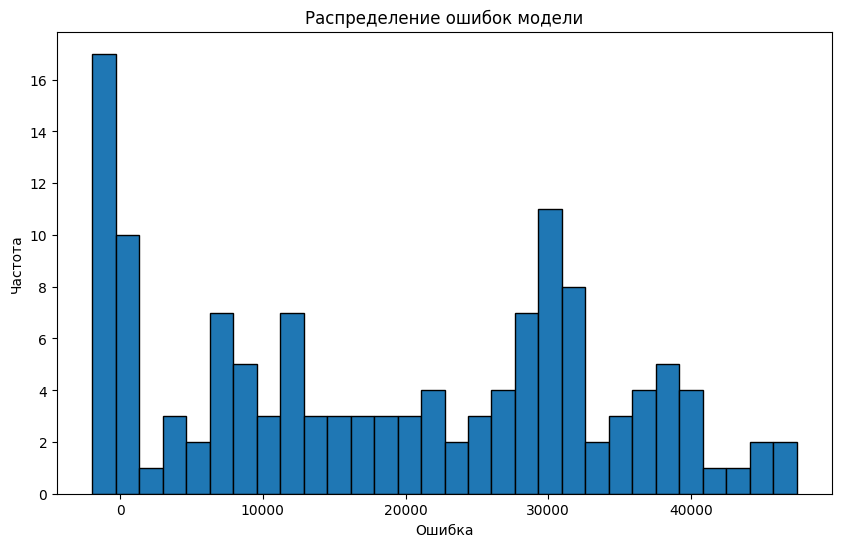

In [12]:
import matplotlib.pyplot as plt

# Ошибки модели
errors = y_test - y_pred

# Гистограмма ошибок
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='black')
plt.title("Распределение ошибок модели")
plt.xlabel("Ошибка")
plt.ylabel("Частота")
plt.show()

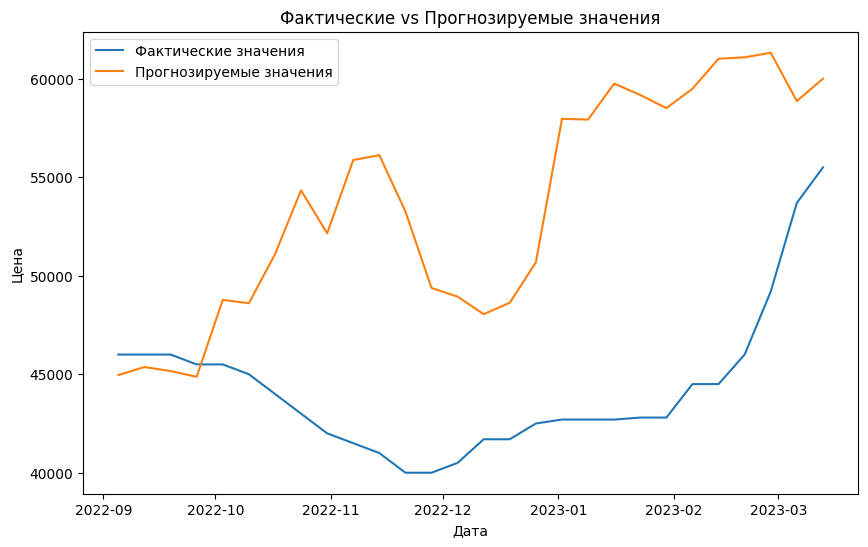

In [7]:
import matplotlib.pyplot as plt

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(test_data["dt"], y_test, label="Фактические значения")
plt.plot(test_data["dt"], y_pred, label="Прогнозируемые значения")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Фактические vs Прогнозируемые значения")
plt.legend()
plt.show()

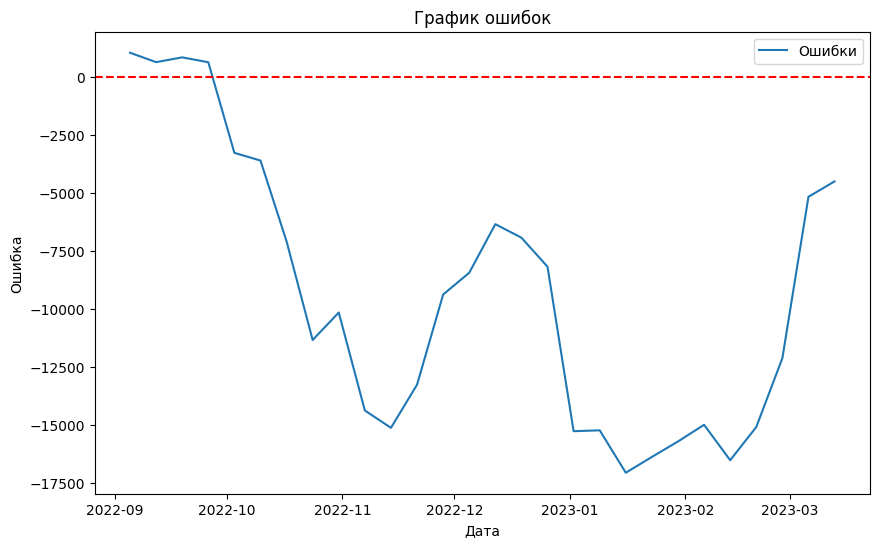

In [8]:
# Вычисляем ошибки
errors = y_test - y_pred

# Визуализация ошибок
plt.figure(figsize=(10, 6))
plt.plot(test_data["dt"], errors, label="Ошибки")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Дата")
plt.ylabel("Ошибка")
plt.title("График ошибок")
plt.legend()
plt.show()

In [9]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Кросс-валидация для временных рядов
tscv = TimeSeriesSplit(n_splits=2)
mae_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=0)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mae_scores.append(mean_absolute_error(y_test, y_pred))

print(f"Средний MAE по кросс-валидации: {np.mean(mae_scores)}")

Средний MAE по кросс-валидации: 12922.869501537873


In [10]:
# Создаем столбец actual_price_after_N_weeks
test_data["actual_price_after_N_weeks"] = test_data["Price"].shift(-1)

# Предположим, что модель рекомендует закупить на 2 недели вперед
test_data["recommended_weeks"] = 2

# Сравниваем текущую цену с ценой через 2 недели
test_data["price_change"] = test_data["actual_price_after_N_weeks"] - test_data["Price"]

# Проверяем, была ли рекомендация правильной
test_data["recommendation_correct"] = test_data.apply(
    lambda row: (row["price_change"] > 0 and row["recommended_weeks"] > 1) or
                (row["price_change"] <= 0 and row["recommended_weeks"] == 1),
    axis=1
)

# Доля правильных рекомендаций
accuracy = test_data["recommendation_correct"].mean()
print(f"Доля правильных рекомендаций: {accuracy * 100:.2f}%")

Доля правильных рекомендаций: 35.71%


<Axes: xlabel='dt', ylabel='Price'>

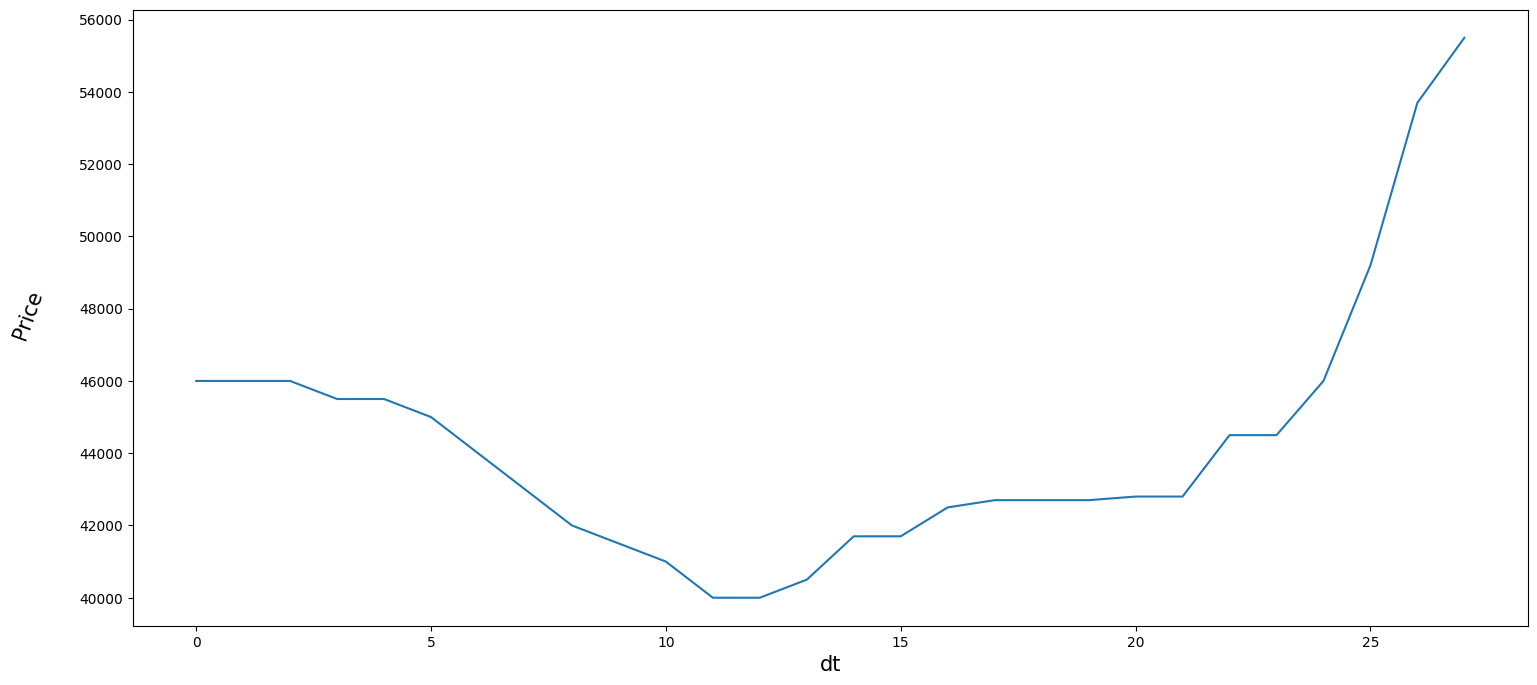

In [11]:
plt.figure(figsize=(18, 8))
plt.xlabel('dt', fontsize=15)
plt.ylabel('Price', rotation=70, labelpad=30, fontsize=15)
test_data["Price"].plot()